In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# One-dimensional Advection Equation

We want to solve the following PDE:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0
\end{equation}

The independent variables (i.e, $x$ and $t$) are used as input values for the NN, and the solution (i.e. $\phi$) is the output. In order to find the solution, at each step the NN outputs are derived w.r.t the inputs. Then, a loss function that matches the PDE is built and the weights are updated accordingly. If the loss function goes to zero, we can assume that our NN is indeed the solution to our PDE. We will try to find a general solution for different values of $u$, so it will be set also as an input.

In [2]:
# imports
import numpy as np 
import matplotlib.pyplot as plt 
import nangs
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.05', '1.10.0')

In [3]:
from nangs import PDE

class Adv1d(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        u = inputs[:,2]
        return {'pde': dpdt + u*dpdx}
                   
pde = Adv1d(inputs=('x', 't', 'u'), outputs='p')

In [4]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [0., 1.], 
    't': [0., 1.], 
    'u': [-1., 1.]
}, device=device, n_samples=1000)

pde.set_sampler(sampler)

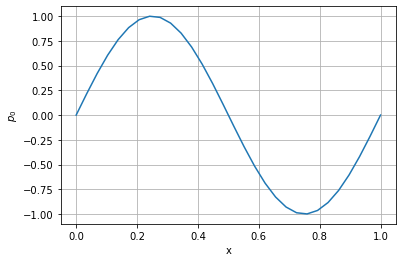

In [5]:
# initial condition (t = 0)

x = np.linspace(0, 1, 30)
p0 = np.sin(2*np.pi*x)

plt.plot(x, p0)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('$p_0$')
plt.show()

In [6]:
# boundary conditions

from nangs import Dirichlet, Periodic

initial_condition = Dirichlet(
    RandomSampler({'x': [0., 1.], 't': 0., 'u': [-1., 1.]}, device=device, n_samples=1000), 
    lambda inputs: {'p' : torch.sin(2.*np.pi*inputs['x'])},
    name="initial"
)

pde.add_boco(initial_condition)

periodic = Periodic(
    RandomSampler({'t': [0., 1.], 'u': [-1., 1.]}, device=device, n_samples=1000), 
    RandomSampler({'x': 0.}, device=device, n_samples=1000), 
    RandomSampler({'x': 1.}, device=device, n_samples=1000), 
    name="periodic2"
)

pde.add_boco(periodic)

In [7]:
# solve

from nangs import MLP

LR = 1e-2
N_STEPS = 1000
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 0.00023, 'initial': 4e-05, 'periodic2': 0.00012}: 100%|███████| 1000/1000 [00:04<00:00, 212.63it/s]

CPU times: user 4.5 s, sys: 234 ms, total: 4.74 s
Wall time: 4.71 s


<AxesSubplot:>

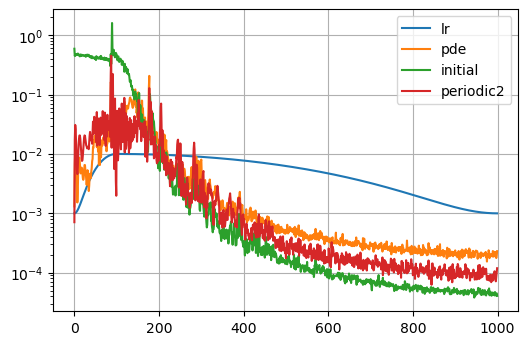

In [8]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

In [9]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, u, t, p):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-u*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

In [10]:
# evaluate

U = 0.5

x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([U])

grid = np.stack(np.meshgrid(x, t, u), -1).reshape(-1, 3)
X = torch.from_numpy(grid).float().to(device)

p = pde.eval(X)
p = p.cpu().numpy().reshape(len(t), -1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames=len(t), fargs=(x, U, t, p), interval=300)
plt.close()

In [11]:
anim